In [25]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

n_detectors = 6
number_of_features = n_detectors*4*8
input_data = []
with open('data/PD_three_rings_with_particle_time_xe9_accuracy_1e-11.dat', 'r') as inpf: 
    l = inpf.readline()
    print(l)
    for line in inpf:
        features = []
        s = line.strip().split()
        b = float(s[0])
        # for i in range(6):
            # for digit in s[i + 1]:
                # features.append(float(digit))
        for digit in s[1:]:
            features.append(float(digit))
        input_data.append([b, features])
    # print(len(input_data))
    
    np.random.shuffle(input_data)
    input_sorted = sorted(input_data, key=lambda x: (x[0]))
    # print(input_data)
    
    features = np.zeros((len(input_data), number_of_features))
    labels = np.zeros((len(input_data), 1))
    incr = 0
    for elem in input_data:
        labels[incr] = np.array(elem[0])
        features[incr] = np.array(elem[1])
        incr += 1
    
    # print(input_sorted[:5])
    # print(input_data[:5])
print(features.shape)

b 8 times 4 radii

(22000, 192)


In [26]:
# Encode labels into segments with equal length
def encode_equi_segment(b: float, maximum: float, groups: int) -> int:
    if b == maximum:
        return groups - 1
    else:
        length_of_segment = maximum / groups
        return int( b // length_of_segment )

    
# Encode labels into segments with equal size
def encode_equi_size(labels_arr: np.ndarray, groups: int ) -> np.ndarray:
    lb_sorted = np.sort(labels_arr, axis=0)
    segment = lb_sorted.shape[0]//groups
    print("Length of segment: {}".format(segment))
    borders = []
    for i in range(groups):   # define borders of segments
        if i != (groups - 1) and i != 0:
            borders.append((lb_sorted[(i)*segment].item(), lb_sorted[(i+1)*segment].item()))
        elif i == 0:
            borders.append((0, lb_sorted[(i+1)*segment].item()))
        else: 
            borders.append((lb_sorted[(i)*segment].item(), lb_sorted[labels.shape[0] - 1].item()))
    print("Encoded into intervals: {}" .format(borders))
    lb_enc = np.zeros_like(labels, dtype=np.int)
    incr = 0
    for elem in labels:   # iterate over all (not sorted) labels and encode them
        gr = 0
        for seg in borders:
            if seg[0] < elem <= seg[1]:
                lb_enc[incr] = gr
                break
            gr += 1
        incr += 1
    return lb_enc


number_of_groups = 4


# labels_encoded_list = []
# maximum_b = np.max(labels)
# for label in labels:
#     labels_encoded_list.append(encode_equi_segment(label[0], maximum_b, number_of_groups))
# labels_encoded = np.array(labels_encoded_list)
# train_labels = torch.flatten(torch.tensor(labels_encoded[:size_of_training_set]))
# test_labels = torch.flatten(torch.tensor(labels_encoded[size_of_training_set:]))


# Divide into test and training sets
size_of_training_set = int(features.shape[0] * 0.8)
size_of_test_set = features.shape[0] - size_of_training_set

train_features = torch.tensor(features[:size_of_training_set], dtype=torch.float32)
test_features = torch.tensor(features[size_of_training_set:], dtype=torch.float32)

print(labels[:10])
labels_encoded_equisized = encode_equi_size(labels, number_of_groups)
print(labels_encoded_equisized[:10])
train_labels = torch.flatten(torch.tensor(labels_encoded_equisized[:size_of_training_set]))
test_labels = torch.flatten(torch.tensor(labels_encoded_equisized[size_of_training_set:]))




print('Set shape: ' + str(features.shape))
print('Train features shape: ' + str(train_features.shape))
print('Train labels shape: ' + str(train_labels.shape))
print('Test features shape: ' + str(test_features.shape))
print('Test labels shape: ' + str(test_labels.shape))

[[ 7.612]
 [11.706]
 [ 8.547]
 [11.588]
 [ 6.798]
 [ 7.727]
 [11.213]
 [10.573]
 [ 8.268]
 [11.53 ]]
Length of segment: 5500
Encoded into intervals: [(0, 6.974), (6.974, 9.814), (9.814, 12.043), (12.043, 16.347)]
[[1]
 [2]
 [1]
 [2]
 [0]
 [1]
 [2]
 [2]
 [1]
 [2]]
Set shape: (22000, 192)
Train features shape: torch.Size([17600, 192])
Train labels shape: torch.Size([17600])
Test features shape: torch.Size([4400, 192])
Test labels shape: torch.Size([4400])


In [27]:
# Linear Fully connected network. 
# Convolutional - three blocks below

def get_correct_predictions(preds: torch.Tensor, values: torch.Tensor) -> int:
    return preds.argmax(dim=1).eq(values).sum().item()

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.lin1 = nn.Linear(in_features = n_detectors*32, out_features = 64)
        nn.init.normal_(self.lin1.weight, mean=0.0, std=0.02)
        
        self.lin2 = nn.Linear(in_features = 64, out_features = 16)
        nn.init.normal_(self.lin2.weight, mean=0.0, std=0.02)
        
        # self.lin3 = nn.Linear(in_features = 16, out_features = 30)
        # nn.init.normal_(self.lin3.weight, mean=0.0, std=0.02)
        
        # self.lin4 = nn.Linear(in_features = 30, out_features = 20)
        # nn.init.normal_(self.lin4.weight, mean=0.0, std=0.02)
        
        # self.lin5 = nn.Linear(in_features = 20, out_features = 12)
        # nn.init.normal_(self.lin5.weight, mean=0.0, std=0.02)
        
        # self.lin6 = nn.Linear(in_features = 12, out_features = 8)
        # nn.init.normal_(self.lin6.weight, mean=0.0, std=0.02)
        
        self.out = nn.Linear(in_features = 16, out_features = number_of_groups)
        nn.init.normal_(self.out.weight, mean=0.0, std=0.02)
        # print(self.lin1.weight[:4, :8])
        # print(self.lin2.weight[:4, :8])
        # print(self.lin3.weight[:4, :8])
        # print(self.out.weight)
        
    def forward(self, t):
        t = t
        t = F.relu(self.lin1(t))
        t = F.relu(self.lin2(t))
        # t = F.relu(self.lin3(t))
        # t = F.relu(self.lin4(t))
        # t = F.relu(self.lin5(t))
        # t = F.relu(self.lin6(t))
        t = F.softmax(self.out(t), dim=1)
        return t

In [28]:
net = Network()
print(net.out.weight)
optimizer = optim.Adam(net.parameters(), lr=0.01)
number_of_epoches = 500
loss_weights = torch.tensor([1.,1.,1.,1.])


total_loss = []
total_accuracy = []
total_val_loss = []
total_val_accuracy = []
for epoch in range(number_of_epoches):
    predicted = net(train_features)
    loss = F.cross_entropy(predicted, train_labels, loss_weights)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    total_correct = get_correct_predictions(predicted, train_labels)
    print("Epoch: {:4d} |---> loss is {:4.10f}, total correct predictions: {:5d}, its {:.3f}%"
      .format(epoch, loss.item(), total_correct, total_correct*100/train_features.shape[0]))
    
    with torch.no_grad():  # record loss and accuracy info for plots
        total_loss.append(loss.item())
        total_accuracy.append(total_correct*100/train_features.shape[0])
        
        test_preds = net(test_features)
        total_val_loss.append(F.cross_entropy(test_preds, test_labels, loss_weights).item())
        total_val_accuracy.append(get_correct_predictions(test_preds, test_labels)*100/test_features.shape[0])

Parameter containing:
tensor([[ 0.0062, -0.0065,  0.0171,  0.0037, -0.0074,  0.0120,  0.0485, -0.0016,
         -0.0262, -0.0098, -0.0133, -0.0244, -0.0243, -0.0097,  0.0219,  0.0259],
        [-0.0296,  0.0387, -0.0205, -0.0087, -0.0216,  0.0002,  0.0136, -0.0018,
         -0.0276,  0.0020,  0.0051, -0.0238, -0.0032, -0.0065,  0.0006,  0.0248],
        [-0.0282, -0.0114, -0.0153, -0.0044, -0.0174, -0.0321,  0.0083,  0.0076,
          0.0160,  0.0157, -0.0025,  0.0060, -0.0152, -0.0169, -0.0207, -0.0168],
        [ 0.0106, -0.0081, -0.0089,  0.0427, -0.0222, -0.0259,  0.0001, -0.0061,
         -0.0129,  0.0114,  0.0250,  0.0236, -0.0194, -0.0219, -0.0290,  0.0168]],
       requires_grad=True)
Epoch:    0 |---> loss is 1.3864766359, total correct predictions:  4406, its 25.034%
Epoch:    1 |---> loss is 1.3829104900, total correct predictions:  7315, its 41.562%
Epoch:    2 |---> loss is 1.3694903851, total correct predictions:  6381, its 36.256%
Epoch:    3 |---> loss is 1.3458870649, 

Epoch:   89 |---> loss is 1.0282402039, total correct predictions: 12735, its 72.358%
Epoch:   90 |---> loss is 1.0280467272, total correct predictions: 12737, its 72.369%
Epoch:   91 |---> loss is 1.0294108391, total correct predictions: 12682, its 72.057%
Epoch:   92 |---> loss is 1.0273411274, total correct predictions: 12754, its 72.466%
Epoch:   93 |---> loss is 1.0290910006, total correct predictions: 12707, its 72.199%
Epoch:   94 |---> loss is 1.0246659517, total correct predictions: 12804, its 72.750%
Epoch:   95 |---> loss is 1.0246541500, total correct predictions: 12779, its 72.608%
Epoch:   96 |---> loss is 1.0224558115, total correct predictions: 12851, its 73.017%
Epoch:   97 |---> loss is 1.0221916437, total correct predictions: 12865, its 73.097%
Epoch:   98 |---> loss is 1.0241658688, total correct predictions: 12787, its 72.653%
Epoch:   99 |---> loss is 1.0219533443, total correct predictions: 12868, its 73.114%
Epoch:  100 |---> loss is 1.0243617296, total correct 

Epoch:  186 |---> loss is 0.9850841165, total correct predictions: 13518, its 76.807%
Epoch:  187 |---> loss is 0.9849482775, total correct predictions: 13526, its 76.852%
Epoch:  188 |---> loss is 0.9844520092, total correct predictions: 13535, its 76.903%
Epoch:  189 |---> loss is 0.9841352701, total correct predictions: 13534, its 76.898%
Epoch:  190 |---> loss is 0.9841053486, total correct predictions: 13539, its 76.926%
Epoch:  191 |---> loss is 0.9838744998, total correct predictions: 13538, its 76.920%
Epoch:  192 |---> loss is 0.9837078452, total correct predictions: 13549, its 76.983%
Epoch:  193 |---> loss is 0.9839897156, total correct predictions: 13538, its 76.920%
Epoch:  194 |---> loss is 0.9850209951, total correct predictions: 13512, its 76.773%
Epoch:  195 |---> loss is 0.9865650535, total correct predictions: 13478, its 76.580%
Epoch:  196 |---> loss is 0.9893251657, total correct predictions: 13424, its 76.273%
Epoch:  197 |---> loss is 0.9902807474, total correct 

Epoch:  282 |---> loss is 0.9748252034, total correct predictions: 13612, its 77.341%
Epoch:  283 |---> loss is 0.9720340371, total correct predictions: 13658, its 77.602%
Epoch:  284 |---> loss is 0.9732340574, total correct predictions: 13656, its 77.591%
Epoch:  285 |---> loss is 0.9709203243, total correct predictions: 13680, its 77.727%
Epoch:  286 |---> loss is 0.9721229076, total correct predictions: 13663, its 77.631%
Epoch:  287 |---> loss is 0.9698191285, total correct predictions: 13697, its 77.824%
Epoch:  288 |---> loss is 0.9710634351, total correct predictions: 13694, its 77.807%
Epoch:  289 |---> loss is 0.9693557024, total correct predictions: 13706, its 77.875%
Epoch:  290 |---> loss is 0.9703494310, total correct predictions: 13695, its 77.812%
Epoch:  291 |---> loss is 0.9690509439, total correct predictions: 13716, its 77.932%
Epoch:  292 |---> loss is 0.9695032835, total correct predictions: 13716, its 77.932%
Epoch:  293 |---> loss is 0.9686213732, total correct 

Epoch:  380 |---> loss is 0.9619716406, total correct predictions: 13784, its 78.318%
Epoch:  381 |---> loss is 0.9619345665, total correct predictions: 13784, its 78.318%
Epoch:  382 |---> loss is 0.9619004130, total correct predictions: 13785, its 78.324%
Epoch:  383 |---> loss is 0.9618647695, total correct predictions: 13785, its 78.324%
Epoch:  384 |---> loss is 0.9618297219, total correct predictions: 13785, its 78.324%
Epoch:  385 |---> loss is 0.9617935419, total correct predictions: 13785, its 78.324%
Epoch:  386 |---> loss is 0.9617527127, total correct predictions: 13786, its 78.330%
Epoch:  387 |---> loss is 0.9617159963, total correct predictions: 13786, its 78.330%
Epoch:  388 |---> loss is 0.9616731405, total correct predictions: 13786, its 78.330%
Epoch:  389 |---> loss is 0.9616134167, total correct predictions: 13788, its 78.341%
Epoch:  390 |---> loss is 0.9615710378, total correct predictions: 13788, its 78.341%
Epoch:  391 |---> loss is 0.9615406394, total correct 

Epoch:  476 |---> loss is 0.9594227076, total correct predictions: 13804, its 78.432%
Epoch:  477 |---> loss is 0.9593481421, total correct predictions: 13804, its 78.432%
Epoch:  478 |---> loss is 0.9592836499, total correct predictions: 13804, its 78.432%
Epoch:  479 |---> loss is 0.9592491388, total correct predictions: 13804, its 78.432%
Epoch:  480 |---> loss is 0.9592339396, total correct predictions: 13804, its 78.432%
Epoch:  481 |---> loss is 0.9592299461, total correct predictions: 13804, its 78.432%
Epoch:  482 |---> loss is 0.9592390656, total correct predictions: 13804, its 78.432%
Epoch:  483 |---> loss is 0.9592721462, total correct predictions: 13804, its 78.432%
Epoch:  484 |---> loss is 0.9593443871, total correct predictions: 13804, its 78.432%
Epoch:  485 |---> loss is 0.9593650103, total correct predictions: 13804, its 78.432%
Epoch:  486 |---> loss is 0.9593605995, total correct predictions: 13804, its 78.432%
Epoch:  487 |---> loss is 0.9592446089, total correct 

Test accuracy is 61.93%


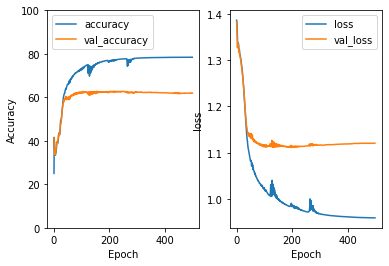

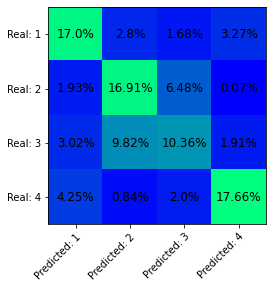

In [29]:
# Graphs and evaluation
with torch.no_grad():
    plt.subplot(1,2,1)
    plt.plot(total_accuracy, label='accuracy')
    plt.plot(total_val_accuracy, label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 100])
    plt.legend(loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(total_loss, label='loss')
    plt.plot(total_val_loss, label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    
    
    test_predictions = net(test_features)
    test_correct_predictions = get_correct_predictions(test_predictions, test_labels)
    print("Test accuracy is {:2.2f}%" .format(test_correct_predictions * 100 /test_features.shape[0]))
    
    stacked = torch.stack((test_labels, test_predictions.argmax(dim=1)), dim=1)
    confusion_matrix = torch.zeros((number_of_groups,number_of_groups), dtype=torch.int32)      # horizontal axis - predicted, vertical - true
    for row in stacked:
       confusion_matrix[row[0].item()][row[1].item()] += 1     # row is target, column - predicted
    # print(confusion_matrix)
    # print(400 - torch.count_nonzero(test_labels_tensor).item())
    
    fig, ax = plt.subplots()
    im = ax.imshow(confusion_matrix, cmap='winter')
    
    ax.set_xticks(np.arange(confusion_matrix.shape[0]))
    ax.set_yticks(np.arange(confusion_matrix.shape[1]))
    x_labels = []
    y_labels = []
    for i in range(confusion_matrix.shape[0]):
        x_labels.append('Predicted: '+ str(i + 1))
        y_labels.append('Real: ' + str(i + 1))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            text = ax.text(j, i, str(round(confusion_matrix[i][j].item()*100/test_features.shape[0], 2)) + '%', ha="center", va="center", size=12)


[[ 7.612]
 [11.706]
 [ 8.547]]
[[1]
 [2]
 [1]]
tensor([[3.3800, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [3.3700, 0.0000, 3.3700, 0.0000],
        [0.0000, 3.4000, 0.0000, 3.4700],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 3.3800, 0.0000],
        [6.7400, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 3.4100, 3.4000]])


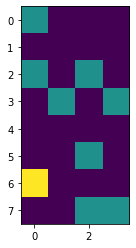

In [30]:
# Convolutional NN
features_reshaped = np.reshape(features, (features.shape[0], n_detectors, 8, 4))

train_features_c = torch.tensor(features_reshaped[:size_of_training_set], dtype=torch.float32)
test_features_c = torch.tensor(features_reshaped[size_of_training_set:], dtype=torch.float32)


print(labels[:3])
print(labels_encoded_equisized[:3])

# Equisized
train_labels_c = torch.flatten(torch.tensor(labels_encoded_equisized[:size_of_training_set]))
test_labels_c = torch.flatten(torch.tensor(labels_encoded_equisized[size_of_training_set:]))

# print(train_features_conv.shape)
print(train_features_c[0][0])
plt.imshow(train_features_c[0][0])
plt.show()
# print(train_features_c[0][1])
# plt.imshow(train_features_c[0][1])
# plt.show()

In [31]:
# Convolutional NN
class NetworkConv(nn.Module):
    def __init__(self):
        super(NetworkConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=n_detectors, out_channels=n_detectors*2, kernel_size=(4, 2))
        nn.init.normal_(self.conv1.weight, mean=0.0, std=0.02)
        # print(self.conv1.weight)
        # self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=2)
        
        self.lin1 = nn.Linear(in_features=n_detectors*2*5*3, out_features=60)
        nn.init.normal_(self.lin1.weight, mean=0.0, std=0.02)
        
        self.lin2 = nn.Linear(in_features=60, out_features=16)
        nn.init.normal_(self.lin2.weight, mean=0.0, std=0.02)

        # self.lin3 = nn.Linear(in_features=30, out_features=12)
        # nn.init.normal_(self.lin3.weight, mean=0.0, std=0.02)
        
        # self.lin4 = nn.Linear(in_features=30, out_features=16)
        # nn.init.normal_(self.lin4.weight, mean=0.0, std=0.02) 
        
        self.out = nn.Linear(in_features=16, out_features=number_of_groups)
        nn.init.normal_(self.out.weight, mean=0.0, std=0.02)
        
    def forward(self, t):
        t = t
        t = F.relu(self.conv1(t))
        # t = F.relu(self.conv2(t))
        # t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        t = F.relu(self.lin1(t.reshape(-1, n_detectors*2*5*3)))
        t = F.relu(self.lin2(t))
        # t = F.relu(self.lin3(t))
        # t = F.relu(self.lin4(t))
        
        t = F.softmax(self.out(t), dim=1)
        return t

In [32]:
net_c = NetworkConv()
print(net_c.conv1.weight)
optimizer_c = optim.Adam(net_c.parameters(), lr=0.01, weight_decay=0.0001)
number_of_epoches_c = 500
# Here define weights for loss contribution of segments
loss_weights_c = torch.tensor([1.,1.,1.,1.])

total_loss_c = []
total_accuracy_c = []
total_val_loss_c = []
total_val_accuracy_c = []
for epoch in range(number_of_epoches_c):
    predicted_c = net_c(train_features_c)
    loss_c = F.cross_entropy(predicted_c, train_labels_c, loss_weights_c)
    optimizer_c.zero_grad()
    loss_c.backward()
    optimizer_c.step()
    
    total_correct_c = get_correct_predictions(predicted_c, train_labels_c)
    print("Epoch: {:4d} |---> loss is {:4.10f}, total correct predictions: {:5d}, its {:.3f}%"
      .format(epoch, loss_c.item(), total_correct_c, total_correct_c*100/train_features_c.shape[0]))
    
    with torch.no_grad():  # record loss and accuracy info for plots
        total_loss_c.append(loss_c.item())
        total_accuracy_c.append(total_correct_c*100/train_features_c.shape[0])
        
        test_preds_c = net_c(test_features_c)
        total_val_loss_c.append(F.cross_entropy(test_preds_c, test_labels_c, loss_weights_c).item())
        total_val_accuracy_c.append(get_correct_predictions(test_preds_c, test_labels_c)*100/test_features_c.shape[0])

Parameter containing:
tensor([[[[ 1.0471e-02, -1.0377e-02],
          [ 2.8475e-02, -3.9719e-03],
          [ 1.6322e-02,  2.0941e-02],
          [-6.8795e-05,  1.8703e-02]],

         [[ 2.4026e-02,  6.7573e-03],
          [ 1.8176e-02,  1.5251e-02],
          [-3.3451e-03, -1.4057e-02],
          [ 1.3354e-02,  2.2560e-02]],

         [[ 5.4009e-02, -3.4461e-03],
          [-3.9473e-02, -9.1835e-03],
          [-1.9593e-02,  4.9147e-03],
          [ 6.5960e-03,  5.0465e-03]],

         [[-2.2537e-02,  1.8220e-02],
          [-2.9908e-02, -1.9082e-02],
          [-2.6833e-02,  4.8387e-03],
          [-1.0307e-02,  9.0943e-03]],

         [[-6.6958e-03,  2.1404e-02],
          [ 2.9654e-02,  1.5977e-02],
          [-4.1099e-02,  3.0748e-02],
          [-3.3664e-02,  2.8667e-02]],

         [[ 1.7540e-02,  2.7797e-03],
          [-4.0291e-02,  5.5808e-03],
          [-2.6618e-02, -2.7916e-02],
          [ 1.9060e-02, -1.8054e-03]]],


        [[[ 3.8291e-02,  7.0446e-03],
          [ 7.

Epoch:    1 |---> loss is 1.3866521120, total correct predictions:  4385, its 24.915%
Epoch:    2 |---> loss is 1.3852952719, total correct predictions:  4385, its 24.915%
Epoch:    3 |---> loss is 1.3811023235, total correct predictions:  3523, its 20.017%
Epoch:    4 |---> loss is 1.3717522621, total correct predictions:  3968, its 22.545%
Epoch:    5 |---> loss is 1.3551307917, total correct predictions:  4223, its 23.994%
Epoch:    6 |---> loss is 1.3437691927, total correct predictions:  4295, its 24.403%
Epoch:    7 |---> loss is 1.3337380886, total correct predictions:  4836, its 27.477%
Epoch:    8 |---> loss is 1.3216263056, total correct predictions:  6667, its 37.881%
Epoch:    9 |---> loss is 1.3256151676, total correct predictions:  8572, its 48.705%
Epoch:   10 |---> loss is 1.3159121275, total correct predictions:  7271, its 41.312%
Epoch:   11 |---> loss is 1.3137392998, total correct predictions:  7315, its 41.562%
Epoch:   12 |---> loss is 1.2916516066, total correct 

Epoch:   98 |---> loss is 1.0928142071, total correct predictions: 11388, its 64.705%
Epoch:   99 |---> loss is 1.0929024220, total correct predictions: 11358, its 64.534%
Epoch:  100 |---> loss is 1.0938491821, total correct predictions: 11345, its 64.460%
Epoch:  101 |---> loss is 1.0935356617, total correct predictions: 11308, its 64.250%
Epoch:  102 |---> loss is 1.0931237936, total correct predictions: 11345, its 64.460%
Epoch:  103 |---> loss is 1.0902929306, total correct predictions: 11425, its 64.915%
Epoch:  104 |---> loss is 1.0888136625, total correct predictions: 11455, its 65.085%
Epoch:  105 |---> loss is 1.0881966352, total correct predictions: 11462, its 65.125%
Epoch:  106 |---> loss is 1.0882488489, total correct predictions: 11469, its 65.165%
Epoch:  107 |---> loss is 1.0890178680, total correct predictions: 11438, its 64.989%
Epoch:  108 |---> loss is 1.0886869431, total correct predictions: 11436, its 64.977%
Epoch:  109 |---> loss is 1.0890359879, total correct 

Epoch:  194 |---> loss is 1.0776222944, total correct predictions: 11638, its 66.125%
Epoch:  195 |---> loss is 1.0611853600, total correct predictions: 12062, its 68.534%
Epoch:  196 |---> loss is 1.0669478178, total correct predictions: 11873, its 67.460%
Epoch:  197 |---> loss is 1.0791965723, total correct predictions: 11581, its 65.801%
Epoch:  198 |---> loss is 1.0651272535, total correct predictions: 11935, its 67.812%
Epoch:  199 |---> loss is 1.0703032017, total correct predictions: 11800, its 67.045%
Epoch:  200 |---> loss is 1.0720010996, total correct predictions: 11763, its 66.835%
Epoch:  201 |---> loss is 1.0672535896, total correct predictions: 11876, its 67.477%
Epoch:  202 |---> loss is 1.0602197647, total correct predictions: 12044, its 68.432%
Epoch:  203 |---> loss is 1.0749000311, total correct predictions: 11722, its 66.602%
Epoch:  204 |---> loss is 1.0626188517, total correct predictions: 11987, its 68.108%
Epoch:  205 |---> loss is 1.0692448616, total correct 

Epoch:  291 |---> loss is 1.0460976362, total correct predictions: 12318, its 69.989%
Epoch:  292 |---> loss is 1.0468335152, total correct predictions: 12284, its 69.795%
Epoch:  293 |---> loss is 1.0441660881, total correct predictions: 12363, its 70.244%
Epoch:  294 |---> loss is 1.0439171791, total correct predictions: 12364, its 70.250%
Epoch:  295 |---> loss is 1.0453722477, total correct predictions: 12331, its 70.062%
Epoch:  296 |---> loss is 1.0420129299, total correct predictions: 12407, its 70.494%
Epoch:  297 |---> loss is 1.0425548553, total correct predictions: 12389, its 70.392%
Epoch:  298 |---> loss is 1.0432034731, total correct predictions: 12400, its 70.455%
Epoch:  299 |---> loss is 1.0423622131, total correct predictions: 12404, its 70.477%
Epoch:  300 |---> loss is 1.0408382416, total correct predictions: 12438, its 70.670%
Epoch:  301 |---> loss is 1.0402407646, total correct predictions: 12468, its 70.841%
Epoch:  302 |---> loss is 1.0395041704, total correct 

Epoch:  387 |---> loss is 1.0309191942, total correct predictions: 12604, its 71.614%
Epoch:  388 |---> loss is 1.0446072817, total correct predictions: 12288, its 69.818%
Epoch:  389 |---> loss is 1.0374963284, total correct predictions: 12429, its 70.619%
Epoch:  390 |---> loss is 1.0329985619, total correct predictions: 12545, its 71.278%
Epoch:  391 |---> loss is 1.0224056244, total correct predictions: 12782, its 72.625%
Epoch:  392 |---> loss is 1.0268055201, total correct predictions: 12682, its 72.057%
Epoch:  393 |---> loss is 1.0369765759, total correct predictions: 12446, its 70.716%
Epoch:  394 |---> loss is 1.0319526196, total correct predictions: 12583, its 71.494%
Epoch:  395 |---> loss is 1.0355684757, total correct predictions: 12479, its 70.903%
Epoch:  396 |---> loss is 1.0230515003, total correct predictions: 12756, its 72.477%
Epoch:  397 |---> loss is 1.0299690962, total correct predictions: 12598, its 71.580%
Epoch:  398 |---> loss is 1.0250027180, total correct 

Epoch:  483 |---> loss is 1.0127646923, total correct predictions: 12917, its 73.392%
Epoch:  484 |---> loss is 1.0131270885, total correct predictions: 12939, its 73.517%
Epoch:  485 |---> loss is 1.0108956099, total correct predictions: 12962, its 73.648%
Epoch:  486 |---> loss is 1.0113023520, total correct predictions: 12944, its 73.545%
Epoch:  487 |---> loss is 1.0124348402, total correct predictions: 12943, its 73.540%
Epoch:  488 |---> loss is 1.0108947754, total correct predictions: 12956, its 73.614%
Epoch:  489 |---> loss is 1.0097794533, total correct predictions: 12986, its 73.784%
Epoch:  490 |---> loss is 1.0107636452, total correct predictions: 12978, its 73.739%
Epoch:  491 |---> loss is 1.0105625391, total correct predictions: 12967, its 73.676%
Epoch:  492 |---> loss is 1.0088548660, total correct predictions: 13004, its 73.886%
Epoch:  493 |---> loss is 1.0100635290, total correct predictions: 12999, its 73.858%
Epoch:  494 |---> loss is 1.0161423683, total correct 

Test accuracy is 60.34%


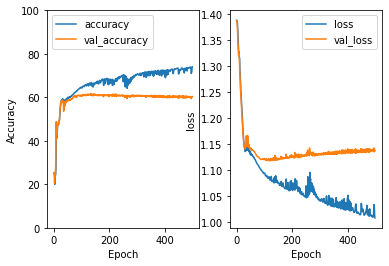

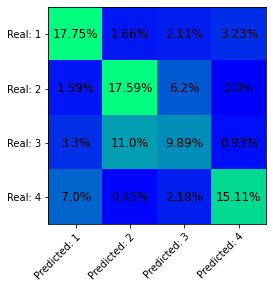

In [33]:
# Graphs and evaluation
with torch.no_grad():
    plt.subplot(1,2,1)
    plt.plot(total_accuracy_c, label='accuracy')
    plt.plot(total_val_accuracy_c, label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 100])
    plt.legend(loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(total_loss_c, label='loss')
    plt.plot(total_val_loss_c, label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    
    
    test_predictions_c = net_c(test_features_c)
    test_correct_predictions_c = get_correct_predictions(test_predictions_c, test_labels_c)
    print("Test accuracy is {:2.2f}%" .format(test_correct_predictions_c * 100 /test_features_c.shape[0]))
    
    stacked_c = torch.stack((test_labels_c, test_predictions_c.argmax(dim=1)), dim=1)
    confusion_matrix_c = torch.zeros((number_of_groups,number_of_groups), dtype=torch.int32)      # horizontal axis - predicted, vertical - true
    for row in stacked_c:
        confusion_matrix_c[row[0].item()][row[1].item()] += 1     # row is target, column - predicted
    
    # print(confusion_matrix)
    # print(400 - torch.count_nonzero(test_labels_tensor).item())
    
    fig, ax = plt.subplots()
    im = ax.imshow(confusion_matrix_c, cmap='winter')
    
    ax.set_xticks(np.arange(confusion_matrix_c.shape[0]))
    ax.set_yticks(np.arange(confusion_matrix_c.shape[1]))
    x_labels = []
    y_labels = []
    for i in range(confusion_matrix_c.shape[0]):
        x_labels.append('Predicted: '+ str(i + 1))
        y_labels.append('Real: ' + str(i + 1))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    for i in range(confusion_matrix_c.shape[0]):
        for j in range(confusion_matrix_c.shape[1]):
            text = ax.text(j, i, str(round(confusion_matrix_c[i][j].item()*100/test_features_c.shape[0],2)) + '%', ha="center", va="center", size=12)

In [34]:
p1 = net_c.lin1.weight.clone().detach()
print(p1.shape)
u, s1, v = torch.svd(p1)
print(s1)
p2 = net_c.lin2.weight.clone().detach()
print(p2.shape)
u, s2, v = torch.svd(p2)
print(s2)

torch.Size([60, 180])
tensor([5.8509e+00, 4.7722e+00, 4.2107e+00, 2.8279e+00, 2.7520e+00, 2.5039e+00,
        2.3486e+00, 2.1076e+00, 2.0159e+00, 1.8725e+00, 1.6458e+00, 1.5499e+00,
        1.5084e+00, 1.3011e+00, 1.1872e+00, 1.1770e+00, 1.0972e+00, 1.0228e+00,
        8.4517e-01, 7.9016e-01, 7.0318e-01, 5.7660e-01, 5.4587e-01, 4.4370e-01,
        4.3103e-01, 3.8869e-01, 3.7050e-01, 3.3818e-01, 3.0510e-01, 2.8451e-01,
        2.4735e-01, 2.1046e-01, 1.9155e-01, 1.8147e-01, 1.6024e-01, 1.5215e-01,
        1.3297e-01, 1.2349e-01, 1.1691e-01, 1.0813e-01, 9.6738e-02, 8.9554e-02,
        8.7246e-02, 7.5562e-02, 7.4372e-02, 7.1657e-02, 6.3605e-02, 6.0752e-02,
        5.1835e-02, 4.8697e-02, 4.5742e-02, 4.3315e-02, 3.8393e-02, 3.6951e-02,
        1.8220e-02, 1.1108e-02, 6.5835e-03, 2.3745e-03, 7.0252e-05, 1.4691e-05])
torch.Size([16, 60])
tensor([4.4479, 3.9111, 2.8382, 1.7617, 1.3033, 0.8572, 0.6947, 0.3375, 0.2980,
        0.2068, 0.1491, 0.1151, 0.0824, 0.0227, 0.0130, 0.0068])
